In [2]:
import numpy as np
pi = np.pi
sqrt = np.sqrt
from matplotlib import pyplot as plt
from matplotlib import colors
from scipy import stats
import os

In [2]:
datadir = './local_simulation_files/'

In [3]:
# unit conversions
transscale = 100 # m/s to cm/s
rotscale = 180/np.pi # rad/s to deg/s
rscale = rotscale/transscale

# convert to physical units
multscale6 = [transscale,transscale,transscale,rotscale,rotscale,rotscale,rotscale]
multscale3 = [transscale,transscale,rotscale,rotscale]
multscale1 = [transscale,rotscale]

# convert color bars
cscale6 = [1,1,1,rscale,rscale,rscale]
cscale3 = [1,1,rscale]
cscale1 = [1,rscale]

# panel titles
veltitles6 = ['Vx','Vy','Vz','Wx','Wy','Wz','heading']
veltitles3 = ['Vx','Vz','Wy','heading']
veltitles1 = ['Vz','heading']

In [4]:
# for simulation saved at filename, plot the median error of component i 
#     unspecified i gives Vz error
#     heading error always i = -1

def plotmederr(filename,i=None,DOFs=6,
               clim=None,logscale=True,cticks=None,hbar=False,nocbar=False,flip=True):
    
    if DOFs == 6:
        multscale = multscale6
        cscale = cscale6
        veltitles = veltitles6
    elif DOFs == 3:
        multscale = multscale3
        cscale = cscale3
        veltitles = veltitles3
    elif DOFs == 1:
        multscale = multscale1
        cscale = cscale1
        veltitles = veltitles1
        
    # find Vz if component unspecified
    if i is None:
        if DOFs == 1:
            i = 0
        elif DOFs == 3:
            i = 1
        elif DOFs == 6:
            i = 2
        
    errs = np.load(filename,allow_pickle=True)['errs']
    mederrs = np.nan*np.ones([np.shape(errs)[0],np.shape(errs)[1]+1])
    mederrs[:,:-1] = np.median(np.abs(errs[:,:,:,i]),axis=-1)
    mederrs[:,-1] = np.median(np.abs(errs[:,0,:,i]),axis=-1) # mirror -180 to +180 
    mederrs = mederrs

    if flip:
        mederrs = np.flipud(mederrs)
        
    #plt.figure(figsize=(4*1.5,2.25*1.5),facecolor='w')

    if logscale:
        if clim is not None:
            plt.imshow(mederrs*multscale[i],cmap='Reds',extent=[-180,180,-90,90],
                       norm=colors.LogNorm(vmin=clim[0],vmax=clim[1]))
        else:
            plt.imshow(mederrs*multscale[i],cmap='Reds',extent=[-180,180,-90,90],
                       norm=colors.LogNorm())
    else:
        plt.imshow(mederrs*multscale[i],cmap='Reds',extent=[-180,180,-90,90])
        if clim is not None:
            plt.clim(clim)
 
    plt.xticks([-180,-90,0,90,180],[])
    plt.yticks([-90,0,90],[])
    plt.title(veltitles[i])
        
    if nocbar:
        plt.tight_layout()
        return

    # format color bar
    if hbar:
        cbar = plt.colorbar(orientation='horizontal')
    else:
        cbar = plt.colorbar()
    if i == -1 or i == DOFs:
        cbarlabel = 'error (deg)'
    elif multscale[i] == rotscale:
        cbarlabel = 'error (deg/s)'
    else:
        cbarlabel = 'error (cm/s)'
    cbar.set_label(cbarlabel)
    if cticks is not None:
        cbar = plt.colorbar(label=cbarlabel)
        cbar.set_ticks(cticks)
        cbar.set_ticklabels(cticks)
    plt.tight_layout()
    
    mederrs_scaled = mederrs*multscale[i]
    
    return mederrs_scaled
    
    

In [5]:
os.listdir(datadir)

['local_67pctsparse_10000trials_0.25noise_sphere_6DOFs_20220709-095811.npz',
 'local_67pctsparse_10000trials_0.25noise_sphere_3DOFs_20220709-110707.npz',
 'local_67pctsparse_10000trials_0.25noise_sphere_1DOFs_20220709-121209.npz',
 'local_67pctsparse_10000trials_0.25noise_spatvarnoise_sphere_3DOFs_20220709-144940.npz',
 'local_67pctsparse_10000trials_0.25noise_floor_3DOFs_20220711-130950.npz',
 '.DS_Store']

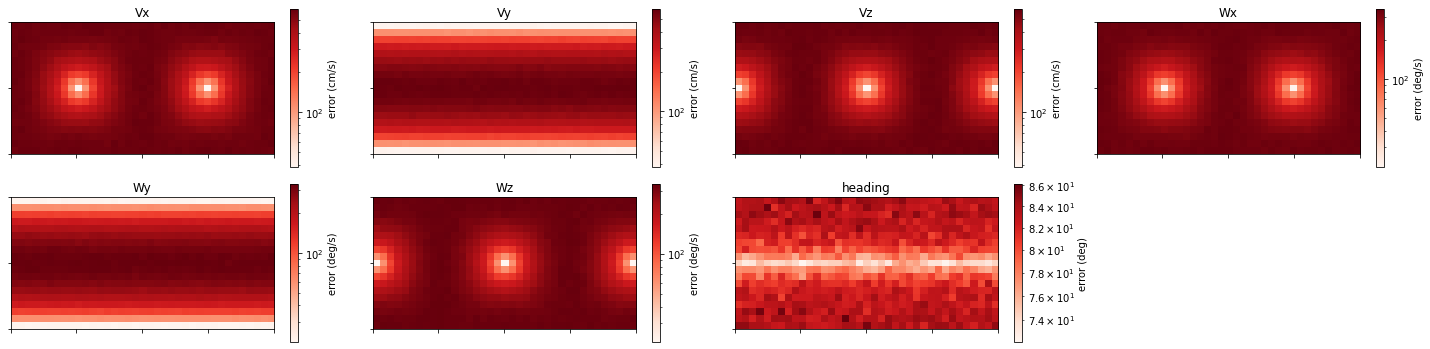

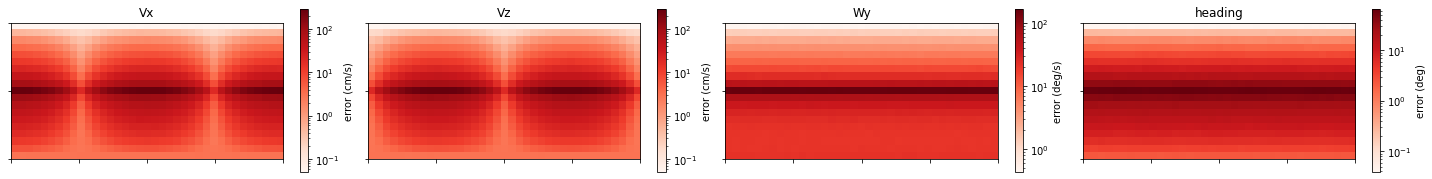

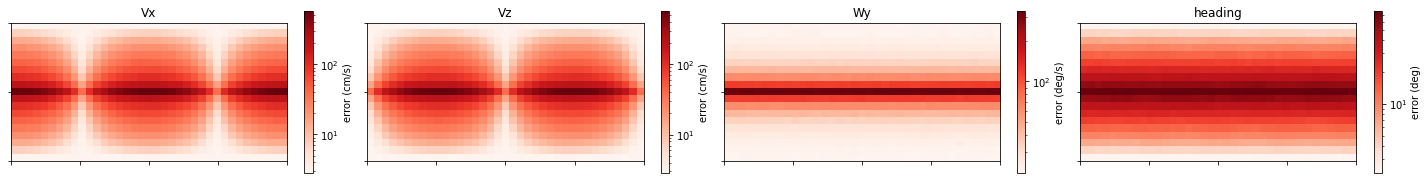

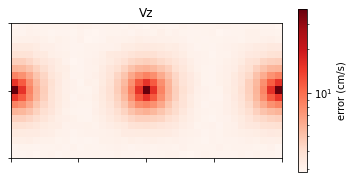

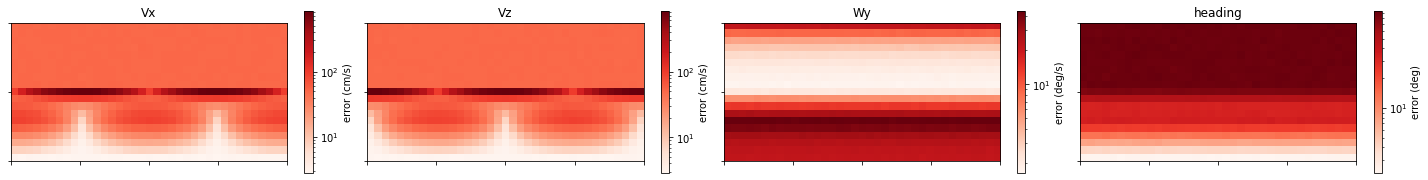

In [6]:
# make rough plots of everything

pctsparses  = [67]
geometries    = ['sphere','floor']
noiselevels   = [0.25]
behavior_DOF_list = [6,3,1]  
spatvarnoises = [1,0]
ntrials = 10000

for pctsparse in pctsparses:

    for geometry in geometries:
        
        for noiselevel in noiselevels:
            
            for behavior_DOF in behavior_DOF_list:
                
                for spatvarnoise in spatvarnoises:
                    
                    for file in os.listdir('./local_simulation_files'):

                        if spatvarnoise == 0:
                            file_starter = f'local_{pctsparse}pctsparse_{ntrials}trials_{noiselevel}noise_{geometry}_{behavior_DOF}DOFs'
                        elif spatvarnoise == 1:
                            file_starter = f'local_{pctsparse}pctsparse_{ntrials}trials_{noiselevel}noise_spatvarnoise_{geometry}_{behavior_DOF}DOFs'

                        if file.startswith(file_starter):    
                            
                            params = file.split('_')
                            DOFs = int(params[-2][0]) 

                             # initialize matrices to save median errors
                            median_error_Vx = np.zeros((19,37))
                            median_error_Vy = np.zeros((19,37))
                            median_error_Vz = np.zeros((19,37))
                            median_error_Wx = np.zeros((19,37))
                            median_error_Wy = np.zeros((19,37))
                            median_error_Wz = np.zeros((19,37))
                            median_error_heading = np.zeros((19,37))
                            
                            plt.figure(figsize=(20,5))
                            
                            if DOFs > 1:
                                these_errors = np.zeros((19,37,DOFs+1))
                                for i in range(DOFs+1):
                                    plt.subplot(2,4,i+1)
                                    these_errors[:,:,i] = plotmederr('./local_simulation_files/'+file,DOFs=DOFs,i=i,logscale=True)
                                    
                                if DOFs == 6:
                                    median_error_Vx = these_errors[:,:,0]
                                    median_error_Vy = these_errors[:,:,1]
                                    median_error_Vz = these_errors[:,:,2]
                                    median_error_Wx = these_errors[:,:,3]
                                    median_error_Wy = these_errors[:,:,4]
                                    median_error_Wz = these_errors[:,:,5]
                                    median_error_heading = these_errors[:,:,6]
                                elif DOFs == 3:
                                    median_error_Vx = these_errors[:,:,0]
                                    median_error_Vz = these_errors[:,:,1]
                                    median_error_Wy = these_errors[:,:,2]
                                    median_error_heading = these_errors[:,:,3]
                                    
                            else:
                                these_errors = np.zeros((19,37,1))
                                plt.subplot(2,4,1)
                                these_errors = plotmederr('./local_simulation_files/'+file,DOFs=DOFs,i=0,logscale=True)
                                
                                median_error_Vz = these_errors
                                
                            plt.savefig(f'./local_plots/plot_{file_starter}_All.png', format='png',dpi=300)
                            
                            # save it all
                            np.savez(f'./local_median_error_files/{file_starter}_median_errors',median_error_Vz=median_error_Vz,median_error_heading=median_error_heading,median_error_Vx=median_error_Vx,median_error_Vy=median_error_Vy,median_error_Wz=median_error_Wz,median_error_Wy=median_error_Wy,median_error_Wx=median_error_Wx)


In [3]:
def cleanplot(data_to_plot=0,logaxis = False,vmin_val=0,vmax_val=0):

    ax = plt.axes()
    plt.axis('equal')
    if logaxis:
        if vmin_val!=0 and vmax_val!=0:
            print('setting maxmin')
            plt.imshow(data_to_plot,cmap='Reds',extent=[-180,180,-90,90],norm=colors.LogNorm(vmin=vmin_val,vmax=vmax_val))
        else:   
            plt.imshow(data_to_plot,cmap='Reds',extent=[-180,180,-90,90],norm=colors.LogNorm())
    else:
        plt.imshow(data_to_plot,cmap='Reds',extent=[-180,180,-90,90])
        
        if vmin_val!=0 and vmax_val!=0:
            plt.clim(vmin_val,vmax_val)
        
    ax.set_box_aspect(1/2)

    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

    plt.tight_layout()

Vz max cm/s= 593.7460089320559
Vz min cm/s= 38.75685175016612
Vx max cm/s= 598.7434849539867
Vx min cm/s= 38.61328945337601
Vy max cm/s= 592.255296810187
Vy min cm/s= 37.86172026391147
Wx max deg/s= 341.40676922955595
Wx min deg/s= 21.187839519540145
Wy max deg/s= 335.49107430460714
Wy min deg/s= 21.10575174950017
Wz max deg/s= 336.7414188357101
Wz min deg/s= 21.728518750119456


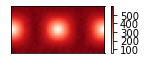

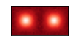

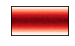

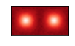

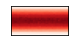

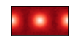

In [5]:
# make nice plots of Vz errors for paper -- probably update so all locals are on log scale

# FIGURE 1
# SPHERE 6DOF 67% sparsity, .25 noise

local_scale = 2/2
plot_width = 2*local_scale
plot_height = 1*local_scale

plot_width_small = 1.5*local_scale
plot_height_small = .75*local_scale

# big plot of Vz
data = np.load('./local_median_error_files/local_67pctsparse_10000trials_0.25noise_sphere_6DOFs_median_errors.npz')

median_error_Vz = data['median_error_Vz']

# max and min for setting colorbar
print('Vz max cm/s=',np.max(median_error_Vz))
print('Vz min cm/s=',np.min(median_error_Vz))

plt.figure(figsize=(plot_width,plot_height))
cleanplot(data_to_plot=median_error_Vz)
plt.clim(50,600)

plt.savefig(f'./final_plots/final_plot_local_67pctsparse_10000trials_0.25noise_sphere_6DOFs_Vz.png', format='png',dpi=300, pad_inches=0)

# add colorbar
cbar = plt.colorbar()
cbar.set_ticks([100, 200, 300, 400, 500])
plt.savefig(f'./final_plots/final_plot_local_67pctsparse_10000trials_0.25noise_sphere_6DOFs_Vz_withcolorbar.png', format='png',dpi=300, pad_inches=0)


# smaller plots of other dirs on same colorscale
median_error_Vx = data['median_error_Vx']
median_error_Vy = data['median_error_Vy']
median_error_Wx = data['median_error_Wx']
median_error_Wy = data['median_error_Wy']
median_error_Wz = data['median_error_Wz']

# max and min for each little plot to report in caption
print('Vx max cm/s=',np.max(median_error_Vx))
print('Vx min cm/s=',np.min(median_error_Vx))
print('Vy max cm/s=',np.max(median_error_Vy))
print('Vy min cm/s=',np.min(median_error_Vy))
print('Wx max deg/s=',np.max(median_error_Wx))
print('Wx min deg/s=',np.min(median_error_Wx))
print('Wy max deg/s=',np.max(median_error_Wy))
print('Wy min deg/s=',np.min(median_error_Wy))
print('Wz max deg/s=',np.max(median_error_Wz))
print('Wz min deg/s=',np.min(median_error_Wz))

plt.figure(figsize=(plot_width_small,plot_height_small))
cleanplot(data_to_plot=median_error_Vx)
plt.clim(50,600)
plt.savefig(f'./final_plots/final_plot_local_67pctsparse_10000trials_0.25noise_sphere_6DOFs_Vx.png', format='png',dpi=300)

plt.figure(figsize=(plot_width_small,plot_height_small))
cleanplot(data_to_plot=median_error_Vy)
plt.clim(50,600)
plt.savefig(f'./final_plots/final_plot_local_67pctsparse_10000trials_0.25noise_sphere_6DOFs_Vy.png', format='png',dpi=300)

plt.figure(figsize=(plot_width_small,plot_height_small))
cleanplot(data_to_plot=median_error_Wx)
plt.clim(20,350)
plt.savefig(f'./final_plots/final_plot_local_67pctsparse_10000trials_0.25noise_sphere_6DOFs_Wx.png', format='png',dpi=300)

plt.figure(figsize=(plot_width_small,plot_height_small))
cleanplot(data_to_plot=median_error_Wy)
plt.clim(20,350)
plt.savefig(f'./final_plots/final_plot_local_67pctsparse_10000trials_0.25noise_sphere_6DOFs_Wy.png', format='png',dpi=300)

plt.figure(figsize=(plot_width_small,plot_height_small))
cleanplot(data_to_plot=median_error_Wz)
plt.clim(20,350)
plt.savefig(f'./final_plots/final_plot_local_67pctsparse_10000trials_0.25noise_sphere_6DOFs_Wz.png', format='png',dpi=300)


Vz max cm/s= 37.689697522449876
Vz min cm/s= 2.8534602586930746
setting maxmin
Vz max cm/s= 569.0794482825693
Vz min cm/s= 2.8733272629439197
setting maxmin


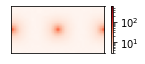

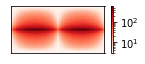

In [8]:
# FIGURE 2 behavior:

local_scale = 2/2
plot_width = 2*local_scale
plot_height = 1*local_scale

do_log = True;
vmin = 2.85
vmax = 569

# SPHERE 1DOF 66% sparsity, .25 noise, Vz

data = np.load('./local_median_error_files/local_67pctsparse_10000trials_0.25noise_sphere_1DOFs_median_errors.npz')
median_error_Vz = data['median_error_Vz']

# max and min for setting colorbar
print('Vz max cm/s=',np.max(median_error_Vz))
print('Vz min cm/s=',np.min(median_error_Vz))

plt.figure(figsize=(plot_width,plot_height))
cleanplot(data_to_plot=median_error_Vz,logaxis=do_log,vmin_val=vmin,vmax_val=vmax)
#plt.clim(0,100)
#plt.imshow(median_error_Vz,cmap='Reds',extent=[-180,180,-90,90],norm=colors.LogNorm(vmin=2,vmax=400))
#cbar = plt.colorbar()

plt.savefig(f'./final_plots/final_plot_local_67pctsparse_10000trials_0.25noise_sphere_1DOFs_Vz.png', format='png',dpi=300)

# add colorbar
cbar = plt.colorbar()
#cbar.set_ticks([100, 200, 300, 400, 500])
plt.savefig(f'./final_plots/final_plot_local_67pctsparse_10000trials_0.25noise_sphere_1DOFs_Vz_withcolorbar.png', format='png',dpi=300, pad_inches=0)



# SPHERE 3DOF 66% sparsity, .25 noise, Vz

data = np.load('./local_median_error_files/local_67pctsparse_10000trials_0.25noise_sphere_3DOFs_median_errors.npz')
median_error_Vz = data['median_error_Vz']

# max and min for setting colorbar
print('Vz max cm/s=',np.max(median_error_Vz))
print('Vz min cm/s=',np.min(median_error_Vz))

plt.figure(figsize=(plot_width,plot_height))
cleanplot(data_to_plot=median_error_Vz,logaxis=do_log,vmin_val=vmin,vmax_val=vmax)
#plt.clim(0,100)
#plt.imshow(median_error_Vz,cmap='Reds',extent=[-180,180,-90,90],norm=colors.LogNorm(vmin=2,vmax=400))
#cbar = plt.colorbar()

plt.savefig(f'./final_plots/final_plot_local_67pctsparse_10000trials_0.25noise_sphere_3DOFs_Vz.png', format='png',dpi=300)

# add colorbar
cbar = plt.colorbar()
#cbar.set_ticks([100, 200, 300, 400, 500])
plt.savefig(f'./final_plots/final_plot_local_67pctsparse_10000trials_0.25noise_sphere_3DOFs_Vz_withcolorbar.png', format='png',dpi=300, pad_inches=0)


Vz max cm/s= 283.88508388068936
Vz min cm/s= 0.05113642109071115
setting maxmin


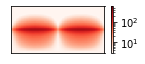

In [9]:
# SPHERE 1DOF 66% sparsity, spatially varying noise, Vz

do_log = True;
vmin = 2.85
vmax = 569

data = np.load('./local_median_error_files/local_67pctsparse_10000trials_0.25noise_spatvarnoise_sphere_3DOFs_median_errors.npz')
median_error_Vz = data['median_error_Vz']

# max and min for setting colorbar
print('Vz max cm/s=',np.max(median_error_Vz))
print('Vz min cm/s=',np.min(median_error_Vz))

plt.figure(figsize=(plot_width,plot_height))
cleanplot(data_to_plot=median_error_Vz,logaxis=do_log,vmin_val=vmin,vmax_val=vmax)
#plt.clim(0,100)
#plt.imshow(median_error_Vz,cmap='Reds',extent=[-180,180,-90,90],norm=colors.LogNorm(vmin=2,vmax=400))
#cbar = plt.colorbar()

plt.savefig(f'./final_plots/final_plot_local_67pctsparse_10000trials_0.25noise_spatvarnoise_sphere_3DOFs_Vz.png', format='png',dpi=300)

# add colorbar
cbar = plt.colorbar()
#cbar.set_ticks([100, 200, 300, 400, 500])
plt.savefig(f'./final_plots/final_plot_local_67pctsparse_10000trials_0.25noise_spatvarnoise_sphere_3DOFs_Vz_withcolorbar.png', format='png',dpi=300, pad_inches=0)



Vz max cm/s= 834.4232582102286
Vz min cm/s= 2.88674227255446
Heading max cm/s= 94.73631168918926
Heading min cm/s= 2.2235326477549835


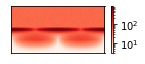

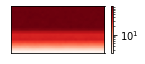

In [154]:
# FIGURE 2 environment: -- plotted on LOG SCALE because distribution blows up with environmental stuff

do_log = True;


# FLOOR 3DOF 66% sparsity, .25 noise, Vz

data = np.load('./local_median_error_files/local_67pctsparse_10000trials_0.25noise_floor_3DOFs_median_errors.npz')
median_error_Vz = data['median_error_Vz']
median_error_heading = data['median_error_heading']

# max and min for setting colorbar
print('Vz max cm/s=',np.max(median_error_Vz))
print('Vz min cm/s=',np.min(median_error_Vz))

# max and min for setting colorbar
print('Heading max cm/s=',np.max(median_error_heading))
print('Heading min cm/s=',np.min(median_error_heading))

# Vz
plt.figure(figsize=(plot_width,plot_height))
cleanplot(data_to_plot=median_error_Vz,logaxis=do_log)
#plt.clim(0,100)
#plt.imshow(median_error_Vz,cmap='Reds',extent=[-180,180,-90,90],norm=colors.LogNorm(vmin=2,vmax=400))
#cbar = plt.colorbar()

plt.savefig(f'./final_plots/final_plot_local_67pctsparse_10000trials_0.25noise_floor_3DOFs_Vz.png', format='png',dpi=300)

# add colorbar
cbar = plt.colorbar()
#cbar.set_ticks([100, 200, 300, 400, 500])
plt.savefig(f'./final_plots/final_plot_local_67pctsparse_10000trials_0.25noise_floor_3DOFs_Vz_withcolorbar.png', format='png',dpi=300, pad_inches=0)

# Heading
plt.figure(figsize=(plot_width,plot_height))
cleanplot(data_to_plot=median_error_heading,logaxis=do_log)
#plt.clim(0,100)
#plt.imshow(median_error_Vz,cmap='Reds',extent=[-180,180,-90,90],norm=colors.LogNorm(vmin=2,vmax=400))
#cbar = plt.colorbar()

plt.savefig(f'./final_plots/final_plot_local_67pctsparse_10000trials_0.25noise_floor_3DOFs_heading.png', format='png',dpi=300)

# add colorbar
cbar = plt.colorbar()
#cbar.set_ticks([100, 200, 300, 400, 500])
plt.savefig(f'./final_plots/final_plot_local_67pctsparse_10000trials_0.25noise_floor_3DOFs_heading_withcolorbar.png', format='png',dpi=300, pad_inches=0)

